In [21]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import string

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [22]:
#speech data comes from a previous project
speech = open("speech.txt").readlines()
print len(speech)
#This line gets rid of some pesky charactesr like smart quotes or the ellipsis character (...)
#If I don't remove them the vectorizers freak out
speech = [filter(lambda x: x in string.printable, s) for s in speech]
print len(speech)


71211
71211


In [23]:
print speech[:5]

['7, 08, marcus,  abajo  get him down \n', '7, 08, house,  what you got against chickens  one got choked last night thanks to you \n', '7, 08, cuddy,  33yearold male with hemoptysis fever \n', '7, 08, house,  cant we even talk about it \n', '7, 08, cuddy,  you cant apologize we cant talk  and puncture wounds \n']


In [57]:
#See how the data looks originally
print "Starting format:"
speech_sample = speech[:5]
print speech_sample
print
#Get rid of the season and episode data and split the speaker and the line
print "Adjusted format:"
adjusted_speech = [re.split(", ", x)[2:] for x in speech]
print adjusted_speech[:5]
print

#Narrow down the list of characters I care about
speaker_labels = ["house", "cameron","chase","cuddy","foreman","wilson", "thirteen","stacy","amber","kutner", "taub"]
main_chars_speech = [x for x in adjusted_speech if x[0] in speaker_labels]
print "Number of lines of speech:"
print len(main_chars_speech)
print

categorized_speech = {}

for line in main_chars_speech:
    if line[0] not in categorized_speech:
        categorized_speech[line[0]] = list(line[1])
    else:
        categorized_speech[line[0]].append(line[1])

#Sanity check that I'm keeping the lines I want
print "Represented keys:"
print categorized_speech.viewkeys()
print
print "Lines per speaker:"
for character in categorized_speech.viewkeys():
    print character + ": " + str(len(categorized_speech[character]))

print

#Huge class imbalance between speakers so I have to upsample
def balance_classes(lineDict):
    maxCount = max([len(x) for x in lineDict.viewvalues()])
    for character in lineDict.viewkeys():
        while len(lineDict[character]) < maxCount:
            lineDict[character].append(lineDict[character][rnd.randint(0, len(lineDict[character])-1)])

balance_classes(categorized_speech)

print            
print "Upsampled lines per speaker:"
for character in categorized_speech.viewkeys():
    print character + ": " + str(len(categorized_speech[character]))
print

final_speech = []
final_labels = []

#Shuffle the lines so I don't get a dev_data set of all one character
for_shuffling = []

for character, lines in categorized_speech.viewitems():
    for line in lines:
        for_shuffling.append((character, line))
        
rnd.shuffle(for_shuffling)


for character, line in for_shuffling:
    final_labels.append(character)
    final_speech.append(line)
        


print
print "Number of final lines and a sample:"
print len(final_labels)
print final_labels[:5]
print len(final_speech)
print final_speech[:5]
    
    

print


#usable_speech = np.ndarray(final_speech)
#usable_labels = np.ndarray(final_labels)
usable_speech = final_speech
usable_labels = final_labels

test_labels = usable_labels[-20000:-10000]
test_data = usable_speech[-20000:-10000]
dev_labels = usable_labels[-10000:]
dev_data = usable_speech[-10000:]
train_labels = usable_labels[:-20000]
train_data = usable_speech[:-20000]


print "Length of training data and a sample:"
print len(train_data)
print len(train_labels)

print train_labels[:50]
print train_data[:50]


Starting format:
['7, 08, marcus,  abajo  get him down \n', '7, 08, house,  what you got against chickens  one got choked last night thanks to you \n', '7, 08, cuddy,  33yearold male with hemoptysis fever \n', '7, 08, house,  cant we even talk about it \n', '7, 08, cuddy,  you cant apologize we cant talk  and puncture wounds \n']

Adjusted format:
[['marcus', ' abajo  get him down \n'], ['house', ' what you got against chickens  one got choked last night thanks to you \n'], ['cuddy', ' 33yearold male with hemoptysis fever \n'], ['house', ' cant we even talk about it \n'], ['cuddy', ' you cant apologize we cant talk  and puncture wounds \n']]

Number of lines of speech:
52622

Represented keys:
dict_keys(['cuddy', 'taub', 'wilson', 'kutner', 'foreman', 'house', 'stacy', 'thirteen', 'cameron', 'amber', 'chase'])

Lines per speaker:
cuddy: 3890
taub: 3378
wilson: 4843
kutner: 988
foreman: 6786
house: 20915
stacy: 484
thirteen: 2094
cameron: 4126
amber: 373
chase: 5312


Upsampled lines pe

In [42]:
print len(train_labels)
print len(train_data)
print len(dev_labels)
print len(dev_data)
print len(test_labels)
print len(test_data)

210065
210065
10000
10000
10000
10000


In [48]:
#with unigrams the best I could get was around 60%.  With 1-2grams I get 85.  
#I'm scared to test my old busted laptop with trigrams.
cv1 = CountVectorizer(ngram_range=(1,2)).fit(train_data)
dtm1 = cv1.transform(train_data)

tf1 = TfidfVectorizer(ngram_range=(1,2)).fit(train_data)
tfidf1 = tf1.transform(train_data)

In [ ]:
#This crashes the kernel for some reason
#lr1 = LogisticRegression().fit(dtm1, train_labels)
#preds = lr1.predict()
#print lr1.score(cv1.transform(dev_data), dev_labels)

In [49]:
nb1 = MultinomialNB().fit(dtm1, train_labels)
predsNB = nb1.predict(cv1.transform(dev_data))
print "Pre grid search score: " + str(nb1.score(cv1.transform(dev_data), dev_labels))
a = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999]
nb1_adjusted = GridSearchCV(nb1, {'alpha': a})
nb1_adjusted.fit(dtm1, train_labels)
print "Post grid search score: " + str(nb1_adjusted.score(cv1.transform(dev_data), dev_labels))
print "Class counts:"
print nb1_adjusted.best_estimator_.class_count_
print "Feature counts:"
print nb1_adjusted.best_estimator_.feature_count_

print
print

nb2 = MultinomialNB().fit(tfidf1, train_labels)
predsNB2 = nb2.predict(tf1.transform(dev_data))
print "Pre grid search score: " + str(nb2.score(tf1.transform(dev_data), dev_labels))
a = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99,.999,.9999]
nb2_adjusted = GridSearchCV(nb2, {'alpha': a})
nb2_adjusted.fit(tfidf1, train_labels)
print "Post grid search score: "+ str(nb2_adjusted.score(tf1.transform(dev_data), dev_labels))
print "Class counts:"
print nb2_adjusted.best_estimator_.class_count_
print "Feature counts:"
print nb2_adjusted.best_estimator_.feature_count_




0.7791
0.8298
Class counts:
[ 19136.  19116.  19085.  19138.  19020.  19079.  19093.  19087.  19083.
  19165.  19063.]
Feature counts:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 9.  9.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  3. ...,  0.  0.  0.]]


0.7846
0.8501
Class counts:
[ 19136.  19116.  19085.  19138.  19020.  19079.  19093.  19087.  19083.
  19165.  19063.]
Feature counts:
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 2.39536692  2.41639455  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.42478196 ...,  0.          0.          0.        ]]


[[762  15  12   8   7   7   4   0   2   7  11]
 [  0 704  12   4  14  33   4   2   3   4  10]
 [  0  10 767   5  16  48   4   1   5   1   4]
 [  1  13  16 787  14  59   3   3  23   8  26]
 [  0  15  19   2 795  89   5   3   8   7  12]
 [  0  18  16  13  45 572   2   0  18   5  29]
 [  0  10  10   7   5   7 835   3   8   9   7]
 [  0  27  10  14  13  19  12 822  11  11  19]
 [  0  11   9   5   9  32   2   2 810   0  11]
 [146  17  17  15  15  19  31  53  32 859  22]
 [  0  16  11  13  18  51   3   0   8   4 788]]


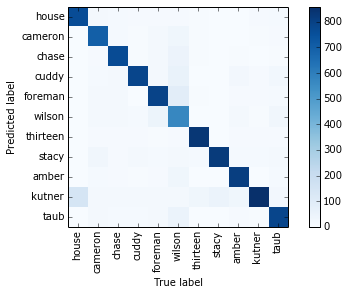

In [50]:
predsANB2 = nb2_adjusted.predict(tf1.transform(dev_data))
probsANB2 = nb2_adjusted.predict_proba(tf1.transform(dev_data))
cm_ANB2 = confusion_matrix(predsANB2, dev_labels)
print cm_ANB2
plt.imshow(cm_ANB2, interpolation = "nearest", cmap = plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(speaker_labels))
plt.xticks(tick_marks, speaker_labels, rotation=90)
plt.yticks(tick_marks, speaker_labels)
plt.tight_layout()
plt.ylabel('Predicted label')
plt.xlabel('True label')

In [52]:
verbose1 = False
if verbose1:
    predsANB = nb1_adjusted.predict(cv1.transform(dev_data))
    probsANB = nb1_adjusted.predict_proba(cv1.transform(dev_data))
    for i in range(100):
        if (dev_labels[i] != predsANB[i]):
            print "==============="
            print "Actual: " + dev_labels[i]
            print "Pred  : " + predsANB[i]
            print speaker_labels
            print "Probs: " + str(probsANB[i])
            print "Text  " + dev_data[i]
            print "==============="
        




verbose2 = True
if verbose2:
    for i in range(100):
        if (dev_labels[i] != predsANB2[i]):
            print "==============="
            print "Actual: " + dev_labels[i]
            print "Pred  : " + predsANB2[i]
            print 
            print "Probs: " + str(probsANB2[i])
            print "Text : " + dev_data[i]
            print "==============="

Actual: house
Pred  : cuddy

Probs: [ 0.00270399  0.11318028  0.17418507  0.39528124  0.03859254  0.14211852
  0.01539849  0.00062657  0.01585692  0.00527216  0.09678422]
Text : well of course its not gallstones who thought it was gallstones 

Actual: taub
Pred  : thirteen

Probs: [  2.82634778e-04   2.40314549e-04   2.33340220e-04   2.30334018e-04
   8.27451092e-03   2.02964114e-04   4.33024580e-01   2.34697497e-04
   4.91320564e-02   5.07917755e-01   2.26813110e-04]
Text : sophia 

Actual: foreman
Pred  : house

Probs: [  4.00262577e-06   7.64777223e-02   4.05259763e-02   1.70627481e-03
   3.70029538e-02   8.36929254e-01   8.75988281e-05   3.36845967e-06
   4.73861099e-03   2.02480648e-03   4.99431611e-04]
Text : treatment would cause him to retain fluid with the kidneys almost shut down already hell die 

Actual: chase
Pred  : cameron

Probs: [  1.13035283e-04   7.21551470e-01   2.35088461e-01   2.67465069e-03
   8.46508379e-03   2.57281162e-02   5.49347280e-05   6.93449254e-04
   1